In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import wilcoxon
import pandas as pd
import os
from explanatory_analysis import SpDataCleaner
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [2]:
df_rf_params = pd.read_csv('reports/5_20.0/best_params_rf_5.0_20.0.csv')
df_rf_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_rf_params.columns

Index(['Model', 'n_estimators', 'min_samples_split', 'min_samples_leaf',
       'max_depth', 'criterion', 'bootstrap'],
      dtype='object')

In [3]:
spdc = SpDataCleaner()
spdc.to_dummies()
moco_survey = spdc.df
X = moco_survey.drop(['choice','ResponseId'], axis=1)
y = moco_survey['choice']


In [4]:
def rq_1_overfitting_rf(df):
    
    df_m1rf = df[df['Model'] == 'M1RF']
    max_depth = df_m1rf['max_depth'].values[0]
    if str(max_depth) == 'nan':
        max_depth = None
    else:
        max_depth = int(max_depth)
        
    rf_M1RF = RandomForestClassifier(n_estimators=df_m1rf['n_estimators'].values[0], max_depth=max_depth,min_samples_split=df_m1rf['min_samples_split'].values[0], min_samples_leaf=df_m1rf['min_samples_leaf'].values[0], criterion=df_m1rf['criterion'].values[0], bootstrap=df_m1rf['bootstrap'].values[0], random_state=42)
    
    
    df_m3rf = df[df['Model'] == 'M3RF']
    max_depth = df_m3rf['max_depth'].values[0]
    if str(max_depth) == 'nan':
        max_depth = None
    else:
        max_depth = int(max_depth)
    
    rf_M3RF = RandomForestClassifier(n_estimators=df_m3rf['n_estimators'].values[0], max_depth=max_depth,min_samples_split=df_m3rf['min_samples_split'].values[0], min_samples_leaf=df_m3rf['min_samples_leaf'].values[0], criterion=df_m3rf['criterion'].values[0], bootstrap=df_m3rf['bootstrap'].values[0], random_state=42)
    
    
    M1RF = []
    M3RF = []
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_val_index,test_index in kfold.split(X):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        
        rf_M1RF.fit(x_train, y_train)
        y_pred_val = rf_M1RF.predict(x_val)
        
        y_pred_test = rf_M1RF.predict(x_test)
        
        M1RF.append(-(accuracy_score(y_test, y_pred_test) - accuracy_score(y_val, y_pred_val))*100)
        
        
    group_fold = GroupKFold(n_splits=10)
    
    for train_val_index,test_index in group_fold.split(X, y, groups=moco_survey['ResponseId']):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        
        rf_M3RF.fit(x_train, y_train)
        y_pred_val = rf_M3RF.predict(x_val)
        
        y_pred_test = rf_M3RF.predict(x_test)
        
        M3RF.append(-(accuracy_score(y_test, y_pred_test) - accuracy_score(y_val, y_pred_val))*100)
        
    return pd.DataFrame({'M1RF': M1RF, 'M3RF': M3RF})

    

In [5]:
df_1= rq_1_overfitting_rf(df_rf_params)  
df_1

,M1RF,M3RF
0,0.742894,20.850566
1,2.232072,17.767419
2,-0.250303,21.098134
3,1.925705,15.924078
4,1.870104,16.169027
5,1.184507,17.285375
6,0.929426,15.774435
7,-1.177417,13.490485
8,-3.031630,16.966914
9,-0.985135,15.552071


In [6]:
df_1.describe()

,M1RF,M3RF
count,10.000000,10.000000
mean,0.344022,17.087850
std,1.681047,2.356532
min,-3.031630,13.490485
25%,-0.801427,15.811846
50%,0.836160,16.567971
75%,1.698705,17.646908
max,2.232072,21.098134


This is to test if the gap between the validation and test accuracy is statistically significant
for the M1RF and M3RF models, which means for the model which was trained and tested on a random sample of the dataset(M1RF) and the model which was trained on a random sample of the dataset and tested on a group of the dataset(M3RF). The null hypothesis is that the gap between the validation and test accuracy is the same for both models. The alternative hypothesis is that the gap between the validation and test accuracy is higher for the M3RF model than the M1RF model. The test used is the Wilcoxon signed-rank test for paired samples. The test is one-sided, as the alternative hypothesis is that the gap between the validation and test accuracy is higher for the M3RF model than the M1RF model. The significance level is 0.05. 

In [7]:
p_value = wilcoxon(df_1['M3RF'],df_1['M1RF'],alternative='greater').pvalue
print(f'p_value: {p_value}')

p_value: 0.0009765625


The gap between the validation and test accuracy is higher for the M3RF model than the M1RF model. The p-value is 0.00098, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that the gap between the validation and test accuracy is higher for the M3RF model than the M1RF model. The following box plot and histogram can be referred.

C:\Users\berha\AppData\Local\Temp\ipykernel_15232\26156864.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


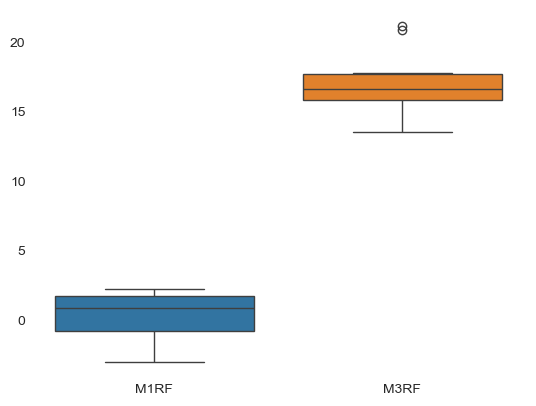

In [33]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_1)
#plt.title('Boxplot of the gap between the validation\n and test accuracy for M1RF and M3RF')
plt.savefig(os.path.join('plots','boxplot_gap_rf.png'))


C:\Users\berha\AppData\Local\Temp\ipykernel_15232\3483924929.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


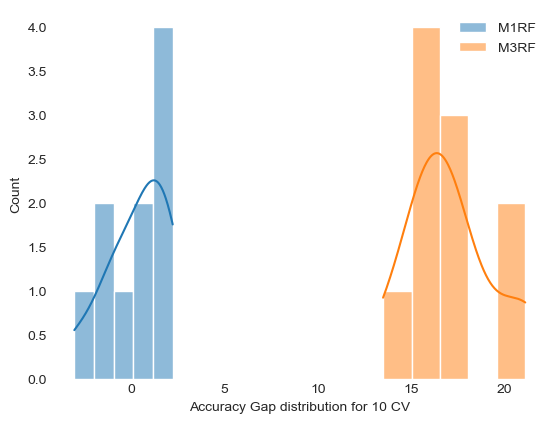

In [34]:
plt.style.use('seaborn-white')
plt.box(False)
sns.histplot(df_1['M1RF'],label='M1RF',kde=True)
sns.histplot(df_1['M3RF'],label='M3RF',kde=True)
plt.xlabel('Accuracy Gap distribution for 10 CV')
plt.legend()
plt.savefig(os.path.join('plots','distribution_gap_rf.png'))


The next test is to check if significantly higher performance value has been achieved by using random sampling(M1RF) than using group sampling(M5RF). The null hypothesis is that the performance metrics the same for both models(there is no difference between the mean performance of both models). The alternative hypothesis is that the performance of M1RF is higher than M5RF. The test used is the Wilcoxon signed-rank test for paired samples. The test is one-sided, as the alternative hypothesis is that accuracy of M1RF is  higher than M5RF. The significance level is 0.05.

In [10]:
def rq_1_performance_rf(df):
    
    df_m1rf = df[df['Model'] == 'M1RF']
    max_depth = df_m1rf['max_depth'].values[0]
    if str(max_depth) == 'nan':
        max_depth = None
    else:
        max_depth = int(max_depth)
        
    rf_M1RF = RandomForestClassifier(n_estimators=df_m1rf['n_estimators'].values[0], max_depth=max_depth,min_samples_split=df_m1rf['min_samples_split'].values[0], min_samples_leaf=df_m1rf['min_samples_leaf'].values[0], criterion=df_m1rf['criterion'].values[0], bootstrap=df_m1rf['bootstrap'].values[0], random_state=42)
    
    
    df_m5rf = df[df['Model'] == 'M5RF']
    max_depth = df_m5rf['max_depth'].values[0]
    if str(max_depth) == 'nan':
        max_depth = None
    else:
        max_depth = int(max_depth)
    
    rf_M5RF = RandomForestClassifier(n_estimators=df_m5rf['n_estimators'].values[0], max_depth=max_depth,min_samples_split=df_m5rf['min_samples_split'].values[0], min_samples_leaf=df_m5rf['min_samples_leaf'].values[0], criterion=df_m5rf['criterion'].values[0], bootstrap=df_m5rf['bootstrap'].values[0], random_state=42)
    
    
    M1RF = []
    M5RF = []
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_val_index,test_index in kfold.split(X):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        
        rf_M1RF.fit(x_train, y_train)
        y_pred_val = rf_M1RF.predict(x_val)
        
        y_pred_test = rf_M1RF.predict(x_test)
        
        M1RF.append(accuracy_score(y_val, y_pred_val)*100)
        
        
    group_fold = GroupKFold(n_splits=10)
    
    for train_val_index,test_index in group_fold.split(X, y, groups=moco_survey['ResponseId']):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        avg_acc = []
        group_fold_2 = GroupKFold(n_splits=9)
        for train_index,val_index in group_fold_2.split(x_train_val, y_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
            x_train, x_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index]
            y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
            
            rf_M5RF.fit(x_train, y_train)
            
            y_pred_val = rf_M5RF.predict(x_val)
            
            y_pred_test = rf_M5RF.predict(x_test)
            
            avg_acc.append(accuracy_score(y_val, y_pred_val)*100)
        
        M5RF.append(np.mean(avg_acc))
        
    return pd.DataFrame({'M1RF': M1RF, 'M5RF': M5RF})

 

In [11]:
df_2= rq_1_performance_rf(df_rf_params)   
df_2

,M1RF,M5RF
0,75.171553,59.543947
1,75.857767,59.608900
2,74.672489,59.403241
3,76.107299,58.751100
4,76.731129,58.607784
5,76.107299,59.232695
6,75.296319,59.137543
7,74.610106,59.080882
8,72.988147,59.083901
9,73.736744,58.580247


In [12]:
df_2.describe()

,M1RF,M5RF
count,10.000000,10.000000
mean,75.127885,59.103024
std,1.156678,0.365411
min,72.988147,58.580247
25%,74.625702,58.833546
50%,75.233936,59.110722
75%,76.044916,59.360604
max,76.731129,59.608900


In [13]:
p_value = wilcoxon(df_2['M1RF'],df_2['M5RF'],alternative='greater').pvalue
print(f'p_value: {p_value}')

p_value: 0.0009765625


Similarly, the model M1RF has a higher performance than M5RF. The p-value is 0.00098, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that the performance of M1RF is higher than M5RF. This inferred a significant data leakage in the first model can be observed.
 The following box plot and histogram can be referred.

C:\Users\berha\AppData\Local\Temp\ipykernel_15232\4045609836.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


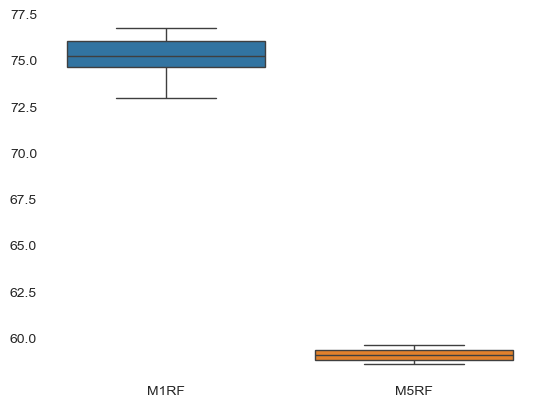

In [35]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_2)
plt.savefig(os.path.join('plots','boxplot_performance_rf.png'))



C:\Users\berha\AppData\Local\Temp\ipykernel_15232\3485872520.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


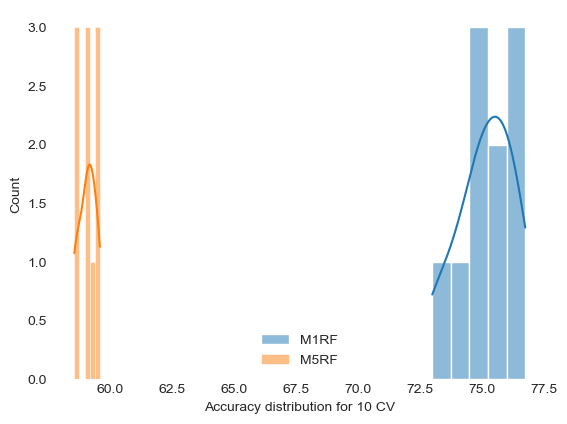

In [36]:
plt.style.use('seaborn-white')
plt.box(False)
sns.histplot(df_2['M1RF'],label='M1RF',kde=True)
sns.histplot(df_2['M5RF'],label='M5RF',kde=True)
plt.xlabel('Accuracy distribution for 10 CV')
plt.legend()
plt.savefig(os.path.join('plots','distribution_performance_rf.png'))


In [16]:
df_ann_params = pd.read_csv('reports/5_20.0/best_params_ann_5.0_20.0.csv')
df_ann_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_ann_params

,Model,n_hidden_layers,n_neurons,learning_rate,batch_size,n_epochs,dropout
0,M1ANN,2,128,0.010,500,25,0.30
1,M2ANN,2,128,0.010,500,25,0.30
2,M3ANN,2,256,0.001,500,45,0.00
3,M4ANN,3,32,0.001,128,60,0.15
4,M5ANN,1,256,0.010,128,60,0.30
5,M6ANN,1,64,0.001,1000,100,0.50
6,M7ANN,3,256,0.010,500,60,0.00
7,M8ANN,3,32,0.001,128,60,0.15
8,M9ANN,3,256,0.010,500,60,0.00
9,M10ANN,3,32,0.001,128,60,0.15


In [17]:
def rq_1_overfitting_nn(df_ann_params):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    scaler = StandardScaler()
    
    M1ANN = []
    M3ANN = []
    
    df_m1ann = df_ann_params[df_ann_params['Model'] == 'M1ANN']
    dropout = df_m1ann['dropout'].values[0]
    n_hidden_layers = df_m1ann['n_hidden_layers'].values[0]
    n_neurons = df_m1ann['n_neurons'].values[0]
    learning_rate = df_m1ann['learning_rate'].values[0]
    batch_size = df_m1ann['batch_size'].values[0]
    n_epochs = df_m1ann['n_epochs'].values[0]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for train_val_index,test_index in kf.split(X):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        
        x_train = x_train.values
        x_val = x_val.values
        x_test = x_test.values
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)
        x_test = scaler.transform(x_test)
        
        m1ann= Sequential()
        m1ann.add(Dense(63, activation='relu'))
        m1ann.add(Dropout(dropout,seed=42))
        for _ in range(n_hidden_layers):
            m1ann.add(Dense(n_neurons, activation='relu'))
            m1ann.add(Dropout(dropout,seed=42))
        m1ann.add(Dense(8, activation='softmax'))
            
        m1ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        m1ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')], validation_data=(x_val, y_val))
        y_pred_val = np.argmax(m1ann.predict(x_val), axis=-1)
        
        y_pred_test = np.argmax(m1ann.predict(x_test), axis=-1)
        
        M1ANN.append(-(accuracy_score(y_test, y_pred_test) - accuracy_score(y_val, y_pred_val))*100)
            
    df_m3ann = df_ann_params[df_ann_params['Model'] == 'M3ANN']
    dropout = df_m3ann['dropout'].values[0]
    n_hidden_layers = df_m3ann['n_hidden_layers'].values[0]
    n_neurons = df_m3ann['n_neurons'].values[0]
    learning_rate = df_m3ann['learning_rate'].values[0]
    batch_size = df_m3ann['batch_size'].values[0]
    n_epochs = df_m3ann['n_epochs'].values[0]
    
    group_fold = GroupKFold(n_splits=10)
    
    for train_val_index,test_index in group_fold.split(X, y, groups=moco_survey['ResponseId']):
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        scaler_1 = StandardScaler()
        x_train = x_train.values
        x_val = x_val.values
        x_test = x_test.values
        
        x_train = scaler_1.fit_transform(x_train)
        x_val = scaler_1.transform(x_val)
        x_test = scaler_1.transform(x_test)
        
        m3ann= Sequential()
        m3ann.add(Dense(63, activation='relu'))
        m3ann.add(Dropout(dropout,seed=42))
        for _ in range(n_hidden_layers):
            m3ann.add(Dense(n_neurons, activation='relu'))
            m3ann.add(Dropout(dropout,seed=42))
        m3ann.add(Dense(8, activation='softmax'))
            
        m3ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        m3ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')], validation_data=(x_val, y_val))
        
        y_pred_val = np.argmax(m3ann.predict(x_val), axis=-1)
        
        
        y_pred_test = np.argmax(m3ann.predict(x_test), axis=-1)
        
        M3ANN.append(-(accuracy_score(y_test, y_pred_test) - accuracy_score(y_val, y_pred_val))*100)
        
    return pd.DataFrame({'M1ANN': M1ANN, 'M3ANN': M3ANN})    


In [18]:
df_3= rq_1_overfitting_nn(df_ann_params)
df_3  

51/51 [==============================] - 0s 1ms/step


,M1ANN,M3ANN
0,-1.381713,25.272098
1,1.520081,19.440170
2,-1.694245,21.043144
3,3.266189,22.935584
4,0.229149,21.874418
5,0.585568,17.131151
6,0.023504,16.360297
7,-0.592928,17.094491
8,-1.059162,17.534445
9,0.975766,18.838166


In [19]:
df_3.describe()

,M1ANN,M3ANN
count,10.000000,10.000000
mean,0.187221,19.752396
std,1.499228,2.945111
min,-1.694245,16.360297
25%,-0.942604,17.231974
50%,0.126327,19.139168
75%,0.878217,21.666599
max,3.266189,25.272098


This is to test if the gap between the validation and test accuracy is statistically significant
for NN models M1ANN and M3ANN. The null hypothesis is that the gap between the validation and test accuracy is the same for both models. The alternative hypothesis is that the gap between the validation and test accuracy is higher for the M3ANN model than the M1ANN model. The test used is the Wilcoxon signed-rank test for paired samples. The test is one-sided, as the alternative hypothesis is that the gap between the validation and test accuracy is higher for the M3ANN model than the M1ANN model. The significance level is 0.05.

In [20]:
p_value = wilcoxon(df_3['M3ANN'],df_3['M1ANN'],alternative='greater').pvalue
print(f'p_value: {p_value}')

p_value: 0.0009765625


Visualizing the gap between the validation and test accuracy for M1ANN and M3ANN models using a box plot and histogram.

C:\Users\berha\AppData\Local\Temp\ipykernel_15232\260051620.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


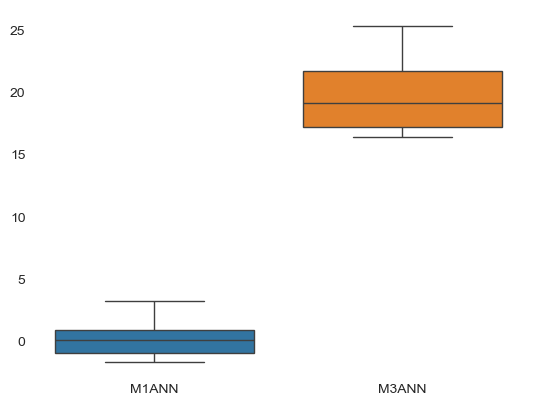

In [37]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_3)
plt.savefig(os.path.join('plots','boxplot_gap_ann.png'))

C:\Users\berha\AppData\Local\Temp\ipykernel_15232\402281826.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


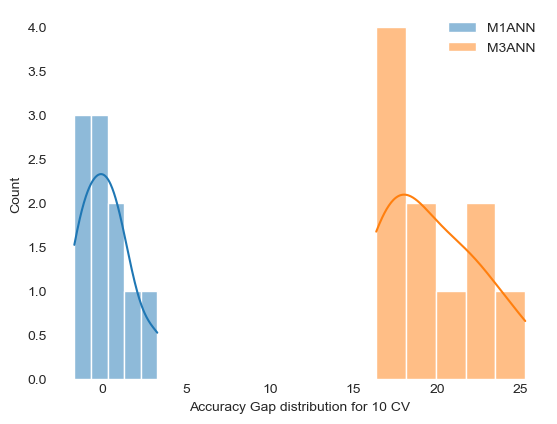

In [38]:
plt.style.use('seaborn-white')
plt.box(False)
sns.histplot(df_3['M1ANN'],label='M1ANN',kde=True)
sns.histplot(df_3['M3ANN'],label='M3ANN',kde=True)
plt.xlabel('Accuracy Gap distribution for 10 CV')
plt.legend()
plt.savefig(os.path.join('plots','distribution_gap_ann.png'))

In [23]:
def rq_1_performance_ann(df):
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    scaler = StandardScaler()
    
    M1ANN = []
    M5ANN = []
    
    df_m1ann = df_ann_params[df_ann_params['Model'] == 'M1ANN']
    dropout = df_m1ann['dropout'].values[0]
    n_hidden_layers = df_m1ann['n_hidden_layers'].values[0]
    n_neurons = df_m1ann['n_neurons'].values[0]
    learning_rate = df_m1ann['learning_rate'].values[0]
    batch_size = df_m1ann['batch_size'].values[0]
    n_epochs = df_m1ann['n_epochs'].values[0]
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for train_val_index,test_index in kf.split(X):
        
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.11, random_state=42)
        
        x_train = x_train.values
        x_val = x_val.values
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)
        
        m1ann= Sequential()
        m1ann.add(Dense(63, activation='relu'))
        m1ann.add(Dropout(dropout,seed=42))
        for _ in range(n_hidden_layers):
            m1ann.add(Dense(n_neurons, activation='relu'))
            m1ann.add(Dropout(dropout,seed=42))
        m1ann.add(Dense(8, activation='softmax'))
            
        m1ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        m1ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')], validation_data=(x_val, y_val))
        y_pred_val = np.argmax(m1ann.predict(x_val), axis=-1)
        
        M1ANN.append(accuracy_score(y_val, y_pred_val)*100)
        
    df_m5ann = df_ann_params[df_ann_params['Model'] == 'M5ANN']
    dropout = df_m5ann['dropout'].values[0]
    n_hidden_layers = df_m5ann['n_hidden_layers'].values[0]
    n_neurons = df_m5ann['n_neurons'].values[0]
    learning_rate = df_m5ann['learning_rate'].values[0]
    batch_size = df_m5ann['batch_size'].values[0]
    n_epochs = df_m5ann['n_epochs'].values[0]
    
    group_fold = GroupKFold(n_splits=10)
    
    for train_val_index,test_index in group_fold.split(X, y, groups=moco_survey['ResponseId']):
        x_train_val, x_test = X.iloc[train_val_index], X.iloc[test_index]
        y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
        
        avg_acc = []
        
        group_fold_2 = GroupKFold(n_splits=9) # to make the test and validation set the same size
        
        for train_index,val_index in group_fold_2.split(x_train_val, y_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
            x_train, x_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index]
            y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
            
            x_train = x_train.values
            x_val = x_val.values
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)
            
            m5ann= Sequential()
            m5ann.add(Dense(63, activation='relu'))
            m5ann.add(Dropout(dropout,seed=42))
            for _ in range(n_hidden_layers):
                m5ann.add(Dense(n_neurons, activation='relu'))
                m5ann.add(Dropout(dropout,seed=42))
            m5ann.add(Dense(8, activation='softmax'))
                
            m5ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            
            m5ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')], validation_data=(x_val, y_val))
            
            y_pred_val = np.argmax(m5ann.predict(x_val), axis=-1)
            
            avg_acc.append(accuracy_score(y_val, y_pred_val)*100)
            
        M5ANN.append(np.mean(avg_acc))
        
    return pd.DataFrame({'M1ANN': M1ANN, 'M5ANN': M5ANN})       
    
    

In [24]:
df_4= rq_1_performance_ann(df_ann_params)
df_4

51/51 [==============================] - 0s 1ms/step


,M1ANN,M5ANN
0,66.437929,57.416109
1,66.313163,56.814436
2,66.063631,57.501280
3,67.997505,56.870074
4,66.936993,56.349835
5,65.502183,56.377321
6,64.878353,57.374803
7,65.003119,56.671632
8,65.751716,57.211115
9,65.252651,56.358025


In [25]:
df_4.describe()

,M1ANN,M5ANN
count,10.000000,10.000000
mean,66.013724,56.894463
std,0.959158,0.457021
min,64.878353,56.349835
25%,65.315034,56.450899
50%,65.907673,56.842255
75%,66.406737,57.333881
max,67.997505,57.501280


In [26]:
p_value = wilcoxon(df_4['M1ANN'],df_4['M5ANN'],alternative='greater').pvalue
print(f'p_value: {p_value}')


p_value: 0.0009765625


C:\Users\berha\AppData\Local\Temp\ipykernel_15232\1047287746.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


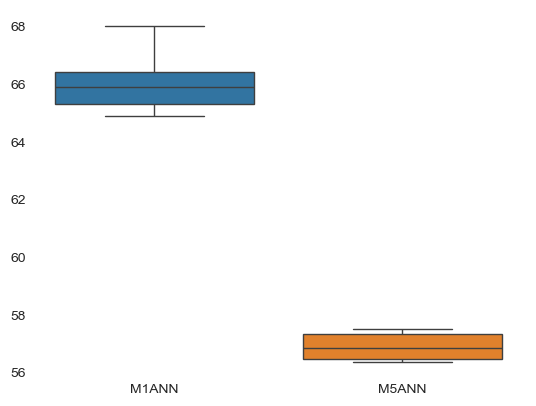

In [39]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_4)
plt.savefig(os.path.join('plots','boxplot_performance_ann.png'))


C:\Users\berha\AppData\Local\Temp\ipykernel_15232\14975195.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


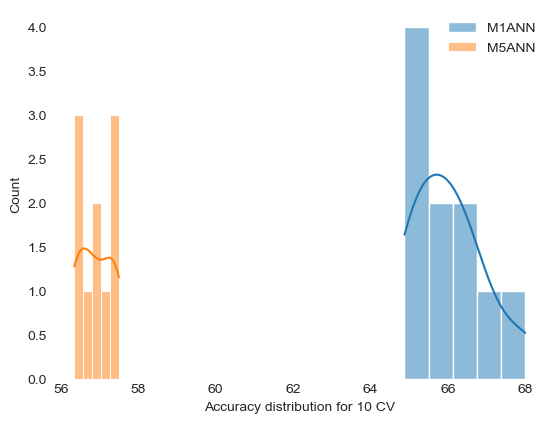

In [32]:
plt.style.use('seaborn-white')
plt.box(False)
sns.histplot(df_4['M1ANN'],label='M1ANN',kde=True)
sns.histplot(df_4['M5ANN'],label='M5ANN',kde=True)
plt.xlabel('Accuracy distribution for 10 CV')
plt.legend()
plt.savefig(os.path.join('plots','distribution_performance_ann.png'))

C:\Users\berha\AppData\Local\Temp\ipykernel_15232\3508466269.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


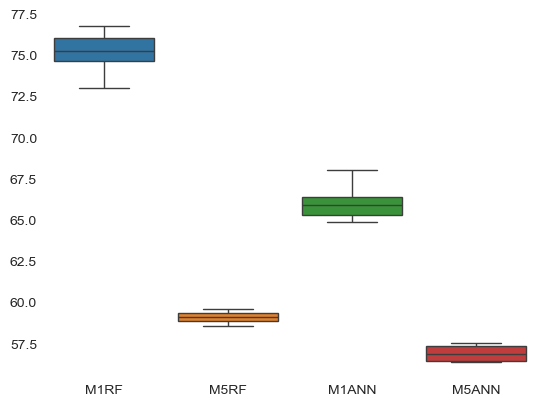

In [40]:
plt.style.use('seaborn-white')
plt.box(False)
df_5 = pd.concat([df_2,df_4],axis=1)
sns.boxplot(data=df_5)
plt.savefig(os.path.join('plots','boxplot_performance_rf_ann.png'))


C:\Users\berha\AppData\Local\Temp\ipykernel_15232\1929838014.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


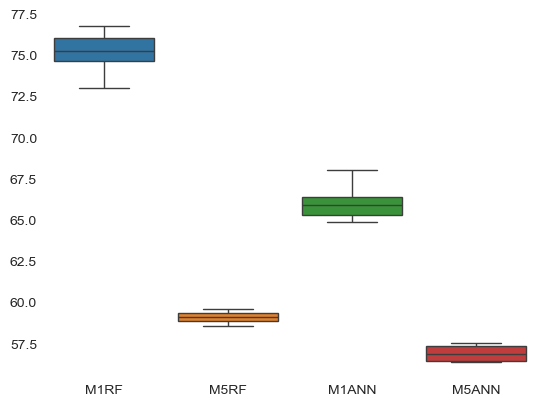

In [31]:
plt.style.use('seaborn-white')
plt.box(False)
df_5 = pd.concat([df_2,df_4],axis=1)
sns.boxplot(data=df_5)
plt.savefig(os.path.join('plots','boxplot_performance_rf_ann_white.png'))